In [224]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


### "Seoul Bike Sharing Demand," UCI Machine Learning Repository, 2020. [Online]. Available: https://doi.org/10.24432/C5F62R.

## linear regression

In [225]:
import pandas as pd

# Load normally
df = pd.read_csv(
    r"C:/Users/zeelp/OneDrive/Desktop/DualAxleSteering-Thesis/Docs/thesis_notes/ML/Seoul_Bike_Sharing_Demand/SeoulBikeData.csv"
)

# Rename all columns
df.columns = [
    "date","bike_count", "hour", "temp", "humidity", "wind_speed",
    "visibility", "dew_point", "radiation", "rainfall", "snowfall",
    "seasons", "holiday", "functioning_day"
]

# Drop the lowercase names (consistent with rename)
df = df.drop(["date", "holiday", "seasons"], axis=1)

print(df.head())


   bike_count  hour  temp  humidity  wind_speed  visibility  dew_point  \
0         254     0  -5.2        37         2.2        2000      -17.6   
1         204     1  -5.5        38         0.8        2000      -17.6   
2         173     2  -6.0        39         1.0        2000      -17.7   
3         107     3  -6.2        40         0.9        2000      -17.6   
4          78     4  -6.0        36         2.3        2000      -18.6   

   radiation  rainfall  snowfall functioning_day  
0        0.0       0.0       0.0             Yes  
1        0.0       0.0       0.0             Yes  
2        0.0       0.0       0.0             Yes  
3        0.0       0.0       0.0             Yes  
4        0.0       0.0       0.0             Yes  


In [226]:
# Convert 'functioning_day' to binary
df["functioning_day"] = (df["functioning_day"] == "Yes").astype(int)

# Keep only rows where hour == 12 (noon)
df = df[df["hour"] == 12]

# Drop hour column after filtering
df = df.drop("hour", axis=1)

df.head()


,bike_count,temp,humidity,wind_speed,visibility,dew_point,radiation,rainfall,snowfall,functioning_day
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


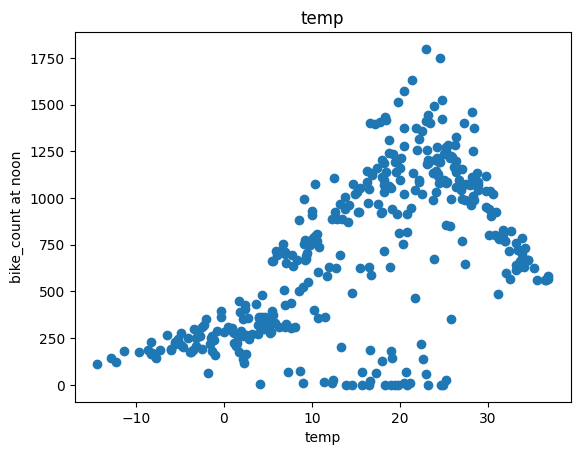

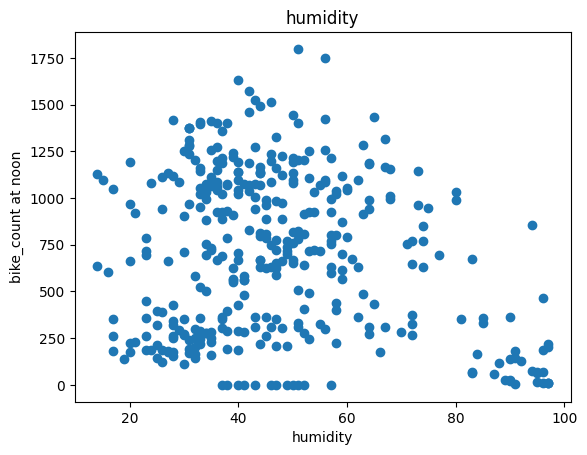

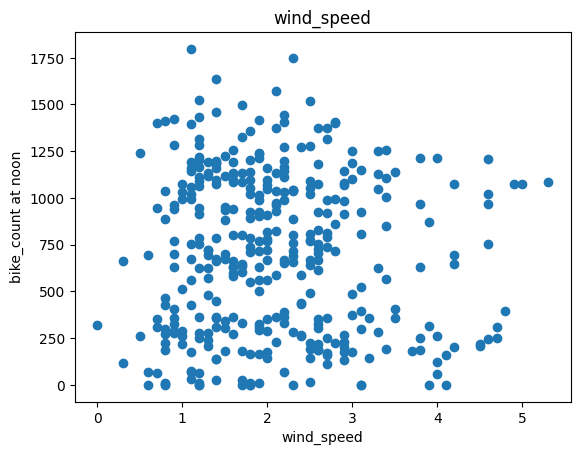

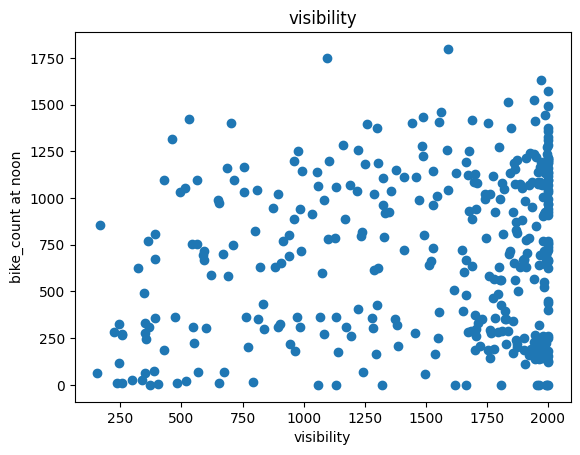

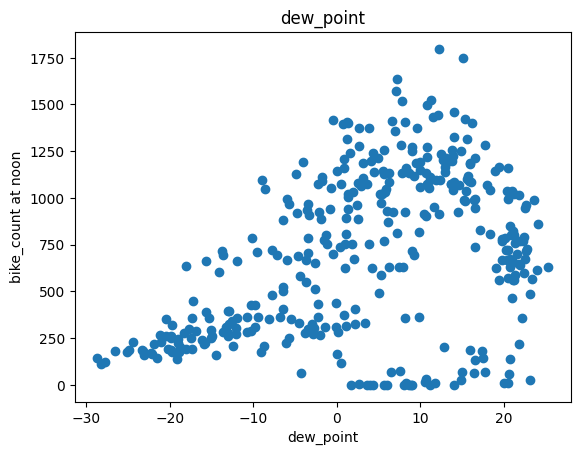

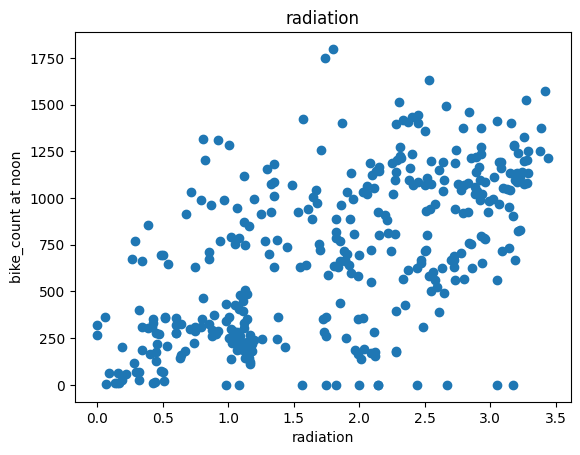

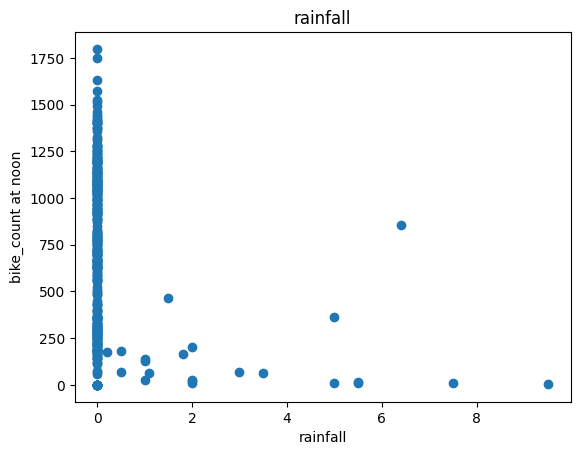

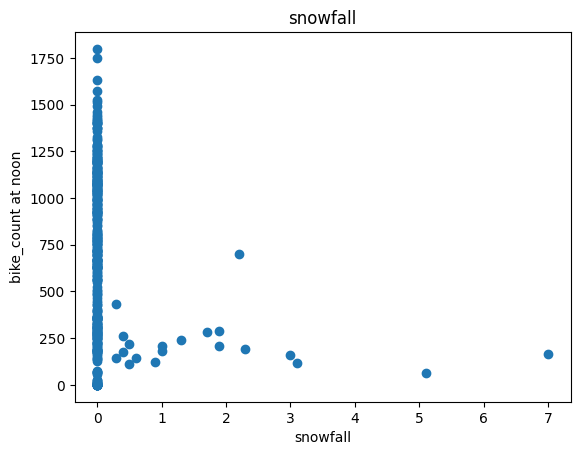

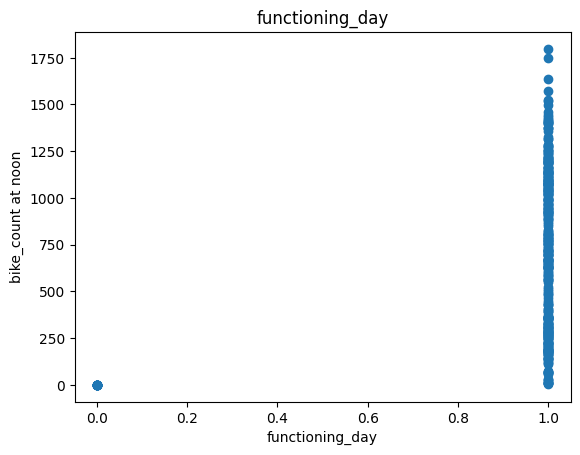

In [227]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel("bike_count at noon")
    plt.show()



In [228]:
df = df.drop(["functioning_day","wind_speed", "visibility"], axis=1)
df.head()

,bike_count,temp,humidity,dew_point,radiation,rainfall,snowfall
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Train, Validation, and Test Split

In [229]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df, test_size=0.4, random_state=42, shuffle=True) # Split into train and temp (temp will be split into valid and test)
valid, test = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True) # Split temp into valid and test sets
print(train.shape, valid.shape, test.shape)


(219, 7) (73, 7) (73, 7)


In [230]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    """
    Get x and y values from a dataframe.
    """
    if x_labels is None:
        x = dataframe[[col for col in dataframe.columns if col != y_label]]
    else:
       if len(x_labels) == 1:
            x = dataframe[x_labels[0]].values.reshape(-1, 1)
       else:  
        x = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((x, y))
    
    return data, x, y

In [231]:
# Features and labels for each set
X_train = train[["temp"]].values
y_train = train["bike_count"].values

X_valid = valid[["temp"]].values
y_valid = valid["bike_count"].values

X_test  = test[["temp"]].values
y_test  = test["bike_count"].values


In [232]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)



(219, 1) (219,)
(73, 1) (73,)
(73, 1) (73,)


Coefficient (slope): 19.908625867440293
Intercept: 393.7747648231196


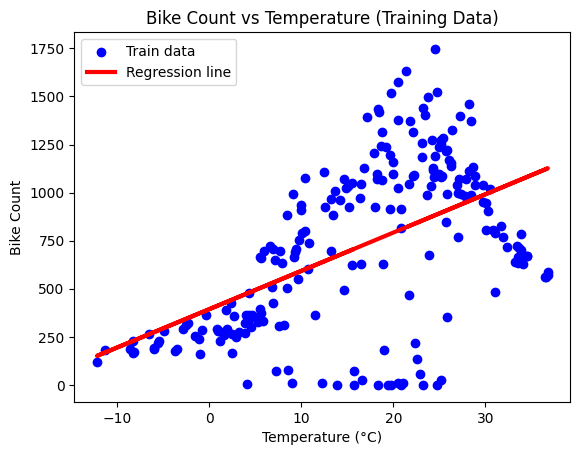

In [233]:
# Train model
temp_reg = LinearRegression()
temp_reg.fit(X_train, y_train)

print("Coefficient (slope):", temp_reg.coef_[0])
print("Intercept:", temp_reg.intercept_)

# Predict on train + test
y_train_pred = temp_reg.predict(X_train)
y_test_pred  = temp_reg.predict(X_test)

# Plot regression line on training data
plt.scatter(X_train, y_train, color="blue", label="Train data")
plt.plot(X_train, y_train_pred, color="red", label="Regression line", linewidth=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike Count")
plt.title("Bike Count vs Temperature (Training Data)")
plt.legend()
plt.show()


In [234]:
temp_reg.score(X_train, y_train)  # R^2 score on training data

0.2849381680350789

## Multiple Linear Regression

In [235]:
from sklearn.model_selection import train_test_split

# Split into train/valid/test
train, temp = train_test_split(df, test_size=0.4, random_state=42, shuffle=True)
valid, test = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)

# Feature columns = everything except target
feature_cols = df.columns.drop("bike_count")

# Features and labels for each set
X_train_all = train[feature_cols].values
y_train_all = train["bike_count"].values

X_valid_all = valid[feature_cols].values
y_valid_all = valid["bike_count"].values

X_test_all = test[feature_cols].values
y_test_all = test["bike_count"].values

In [236]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Train multiple regression
multi_reg = LinearRegression()
multi_reg.fit(X_train_all, y_train_all)

# Predictions
y_valid_pred = multi_reg.predict(X_valid_all)
y_test_pred = multi_reg.predict(X_test_all)

# Evaluation
print("Validation R²:", r2_score(y_valid_all, y_valid_pred))
print("Test R²:", r2_score(y_test_all, y_test_pred))
print("Test MSE:", mean_squared_error(y_test_all, y_test_pred))

print("Coefficients:", multi_reg.coef_)
print("Intercept:", multi_reg.intercept_)


Validation R²: 0.5694408069428503
Test R²: 0.4598200253856244
Test MSE: 85536.23129567475
Coefficients: [  4.13164211  -6.75042648  12.92006162 122.11956284 -44.6854484
 -16.14871183]
Intercept: 706.6538057463002


# Regression with Neural Networks

In [237]:
# Normalizer (adapt on the same feature used)
temp_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=-1)
temp_normalizer.adapt(X_train_temp)

c:\Users\zeelp\anaconda3\envs\ml-gpu\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [238]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,  # Normalize the input
    tf.keras.layers.Dense(units=1) # Single neuron for regression
])

In [239]:
temp_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="mse"
)

In [240]:
history = temp_nn_model.fit(
    X_train_temp, y_train_temp,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0
)

In [241]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

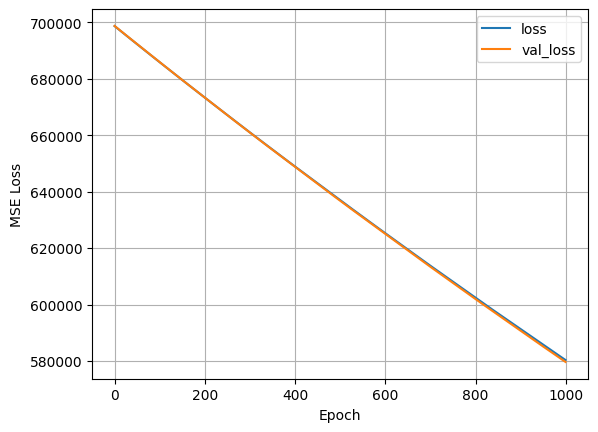

In [242]:
plot_loss(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


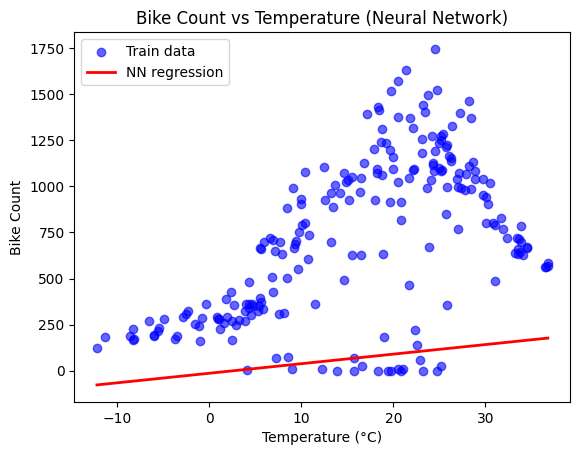

In [243]:
import numpy as np
import matplotlib.pyplot as plt

# Predictions from NN
y_train_pred_nn = temp_nn_model.predict(X_train_temp).flatten()

# Sort values by temperature for a smooth curve
sorted_idx = np.argsort(X_train_temp.flatten())
X_sorted = X_train_temp.flatten()[sorted_idx]
y_sorted = y_train_pred_nn[sorted_idx]

# Plot
plt.scatter(X_train_temp, y_train_temp, color="blue", alpha=0.6, label="Train data")
plt.plot(X_sorted, y_sorted, color="red", linewidth=2, label="NN regression")
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike Count")
plt.title("Bike Count vs Temperature (Neural Network)")
plt.legend()
plt.show()


# Neural Networks

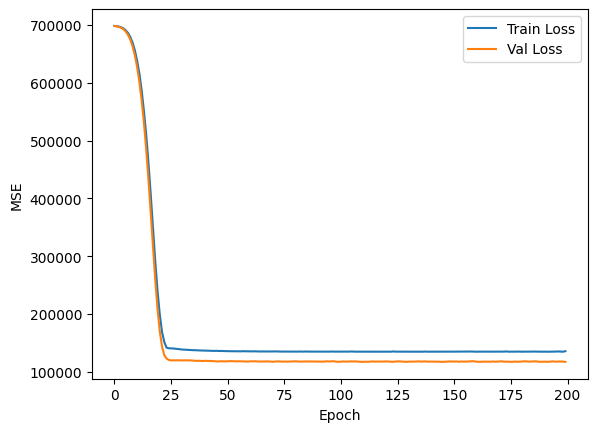

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


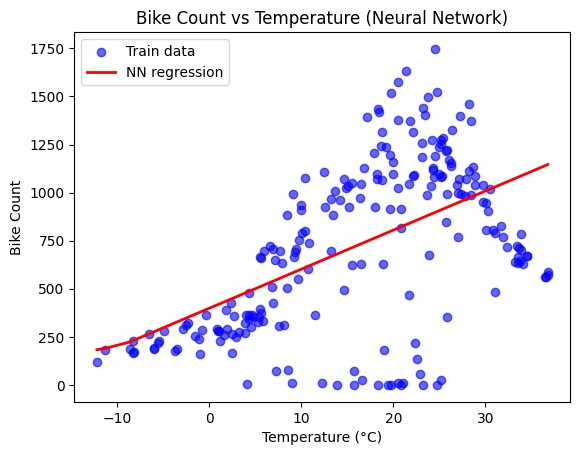

In [244]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Normalizer (adapt on the actual feature used!)
temp_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=-1)
temp_normalizer.adapt(X_train_temp)

# Neural Network with more capacity
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1)   # regression output
])

temp_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="mse"
)

# Train
history = temp_nn_model.fit(
    X_train_temp, y_train_temp,
    epochs=200,  # start smaller than 1000
    validation_data=(X_val_temp, y_val_temp),
    verbose=0
)

# Plot training history
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Predict for plotting
y_train_pred_nn = temp_nn_model.predict(X_train_temp).flatten()

# Sort for smooth curve
sorted_idx = np.argsort(X_train_temp.flatten())
X_sorted = X_train_temp.flatten()[sorted_idx]
y_sorted = y_train_pred_nn[sorted_idx]

# Plot regression curve vs training data
plt.scatter(X_train_temp, y_train_temp, color="blue", alpha=0.6, label="Train data")
plt.plot(X_sorted, y_sorted, color="red", linewidth=2, label="NN regression")
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike Count")
plt.title("Bike Count vs Temperature (Neural Network)")
plt.legend()
plt.show()


In [245]:
from sklearn.metrics import r2_score, mean_squared_error

# Predictions from NN
y_valid_pred_nn = temp_nn_model.predict(X_valid_all[:, [0]])  # [:, [0]] if only temp feature
y_test_pred_nn  = temp_nn_model.predict(X_test_all[:, [0]])

# Evaluation
print("Validation R²:", r2_score(y_valid_all, y_valid_pred_nn))
print("Test R²:", r2_score(y_test_all, y_test_pred_nn))
print("Test MSE:", mean_squared_error(y_test_all, y_test_pred_nn))

# Extract weights (slope) and bias (intercept)
weights, bias = temp_nn_model.layers[1].get_weights()
print("Coefficient (slope):", weights[0][0])
print("Intercept:", bias[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Validation R²: 0.40476542711257935
Test R²: 0.38462942838668823
Test MSE: 97442.4765625
Coefficient (slope): 0.4545052
Intercept: 2.501139


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


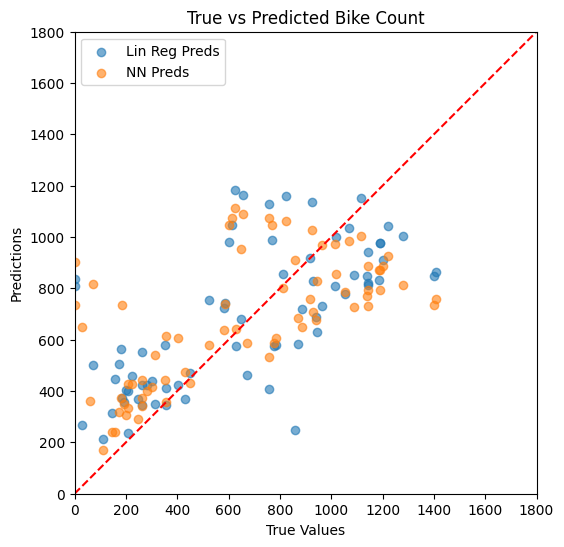

In [247]:
import matplotlib.pyplot as plt

# Predictions
y_pred_lr = multi_reg.predict(X_test_all)  # linear regression
y_pred_nn = temp_nn_model.predict(X_test_all[:, [0]])  # neural net with temp feature

# Plot
plt.figure(figsize=(6,6))
ax = plt.axes(aspect="equal")

plt.scatter(y_test_all, y_pred_lr, alpha=0.6, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, alpha=0.6, label="NN Preds")

lims = [0, 1800]  # adjust if needed
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("True Values")
plt.ylabel("Predictions")

# Perfect prediction line
plt.plot(lims, lims, 'r--')

plt.legend()
plt.title("True vs Predicted Bike Count")
plt.show()
